In [12]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

In [2]:
def read_images(path):
    images = []
    names=[]
    for i in sorted(os.listdir(path),key=len):
        img = cv2.imread(os.path.join(path,i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        images.append(img)
        names.append(i)
    return images,names

In [3]:
src = r'C:\Users\saad\Desktop\Image-Background-Removal\Dataset\Human-Segmentation-Dataset'
inputs = os.path.join(src,'Training_Images')
outputs = os.path.join(src,'Ground_Truth')

In [4]:
in_images,in_names = read_images(inputs)
out_images,out_names = read_images(outputs)

In [5]:
in_images = np.array(in_images)/255.
out_images = np.array(out_images)/255.

[88, 132, 208, 198, 45]


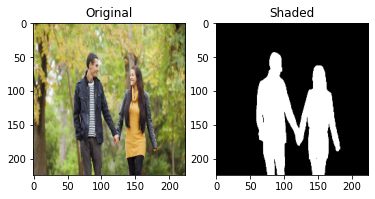

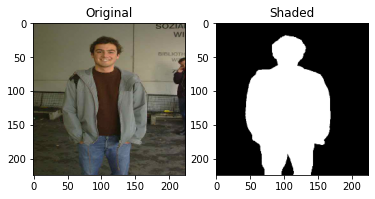

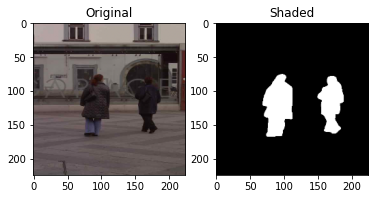

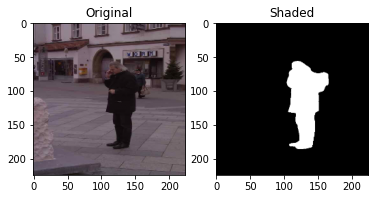

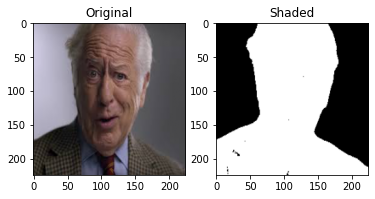

In [6]:
num_test = random.sample(range(0,len(in_images)),5)
print(num_test)
for i in num_test:
    plt.subplot(121)
    plt.imshow(in_images[i])
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(out_images[i])
    plt.title('Shaded')
    plt.show()

In [7]:
x_train,x_test,y_train,y_test = train_test_split(in_images,out_images,test_size=0.2,random_state=42)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(232, 224, 224, 3) (232, 224, 224, 3)
(58, 224, 224, 3) (58, 224, 224, 3)


In [26]:
in1 = Input(shape=(224,224, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

model = Model(inputs=[in1], outputs=[segmentation])

losses = {'seg': 'binary_crossentropy'
    }

metrics = {'seg': ['acc']
        }
model.compile(optimizer="adam", loss = losses, metrics=metrics)


In [27]:
filepath = 'unet.hdf5'
checkpoint =keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)
history= model.fit(x_train,y_train,validation_split=0.2,batch_size=2,epochs=100,callbacks=[checkpoint])

Epoch 1/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6033 - acc: 0.3335 - val_loss: 0.5883 - val_acc: 0.2189
Epoch 2/100
93/93 [==============================] - 2s 17ms/step - loss: 0.5744 - acc: 0.3272 - val_loss: 0.5052 - val_acc: 0.1852
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.5561 - acc: 0.3462 - val_loss: 0.4817 - val_acc: 0.1196
Epoch 4/100
93/93 [==============================] - 1s 16ms/step - loss: 0.5368 - acc: 0.3348 - val_loss: 0.4990 - val_acc: 0.1136
Epoch 5/100
93/93 [==============================] - 2s 17ms/step - loss: 0.5309 - acc: 0.3634 - val_loss: 0.4756 - val_acc: 0.0818
Epoch 6/100
93/93 [==============================] - 1s 16ms/step - loss: 0.5302 - acc: 0.3713 - val_loss: 0.5086 - val_acc: 0.1563
Epoch 7/100
93/93 [==============================] - 2s 17ms/step - loss: 0.5246 - acc: 0.2636 - val_loss: 0.4635 - val_acc: 0.0859
Epoch 8/100
93/93 [==============================] - 2s 17ms/step - loss: 0.

93/93 [==============================] - 1s 16ms/step - loss: 0.1725 - acc: 0.4031 - val_loss: 0.3077 - val_acc: 0.4855
Epoch 63/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1484 - acc: 0.3977 - val_loss: 0.3065 - val_acc: 0.3718
Epoch 64/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1314 - acc: 0.3950 - val_loss: 0.3518 - val_acc: 0.2952
Epoch 65/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1250 - acc: 0.3978 - val_loss: 0.3665 - val_acc: 0.3225
Epoch 66/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1154 - acc: 0.3838 - val_loss: 0.3729 - val_acc: 0.3364
Epoch 67/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1528 - acc: 0.4250 - val_loss: 0.3441 - val_acc: 0.4992
Epoch 68/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1217 - acc: 0.3786 - val_loss: 0.3817 - val_acc: 0.3948
Epoch 69/100
93/93 [==============================] - 1s 16ms/step - loss: 0.1103 

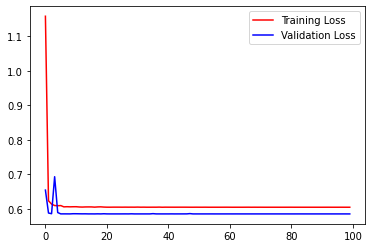

In [44]:
plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

In [51]:
model.load_weights(filepath1)
preds = model.predict(x_test)

[33, 47, 15, 34, 46]


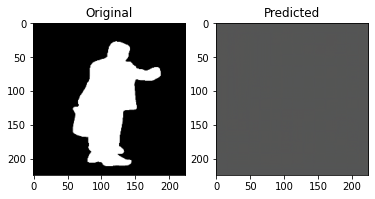

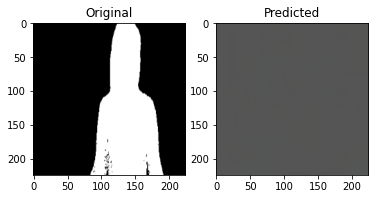

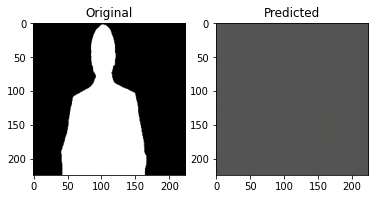

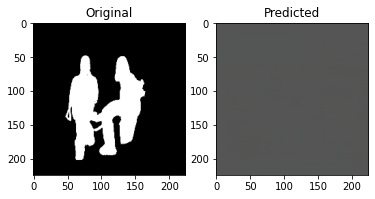

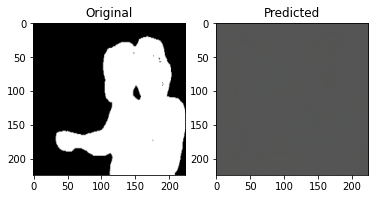

In [52]:
num_test = random.sample(range(0,len(x_test)),5)
print(num_test)
for i in num_test:
    plt.subplot(121)
    plt.imshow(y_test[i])
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(preds[i])
    plt.title('Predicted')
    plt.show()

In [53]:
def make_blur(img):
    # image = cv2.imread(img)
    ksize = (10, 10)
    blur = cv2.blur(img, ksize)
    return blur

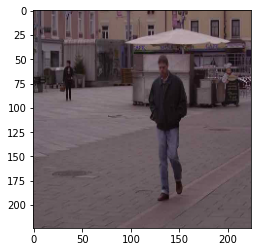

In [32]:
plt.imshow(x_test[43])

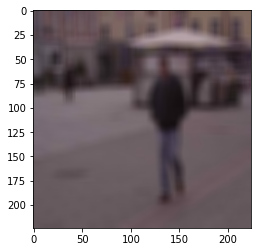

In [33]:
plt.imshow(make_blur(x_test[43]))

In [54]:
def mask_blur(original_img, blur_img, predicted_img):
    # print("Shape: ", original_img.shape, blur_img.shape, predicted_img.shape)
    # cv2.imshow('img', predicted_img)
    # cv2.waitKeyEx(0)

    blue_channel_ori = original_img[:, :, 0]
    green_channel_ori = original_img[:, :, 1]
    red_channel_ori = original_img[:, :, 2]

    blue_channel_blr = blur_img[:, :, 0]
    green_channel_blr = blur_img[:, :, 1]
    red_channel_blr = blur_img[:, :, 2]

    blue_channel_pre = predicted_img[:, :, 0]
    green_channel_pre = predicted_img[:, :, 1]
    red_channel_pre = predicted_img[:, :, 2]

    new_b = []
    new_g = []
    new_r = []

    mks_img_new = np.zeros([224,224, 3])

    for i in range(3):
        if i == 0:
            img = blue_channel_blr
            msk = blue_channel_pre
            ori = blue_channel_ori
        if i == 1:
            img = green_channel_blr
            msk = green_channel_pre
            ori = green_channel_ori
        if i == 2:
            img = red_channel_blr
            msk = red_channel_pre
            ori = red_channel_ori

        if i == 0:
            new = new_b
        if i == 1:
            new = new_g
        if i == 2:
            new = new_r

        img = img.reshape(1, -1)[0]
        msk = msk.reshape(1, -1)[0]
        ori = ori.reshape(1, -1)[0]

        for k, m, o in zip(img, msk, ori):
            if int(m*255.) < 50:
                new.append(k)
            else:
                new.append(o)

        if i == 0:
            new_b = np.array(new_b).reshape(224, 224)
            mks_img_new[:, :, 0] = new_b
        if i == 1:
            new_g = np.array(new_g).reshape(224, 224)
            mks_img_new[:, :, 1] = new_g
        if i == 2:
            new_r = np.array(new_r).reshape(224, 224)
            mks_img_new[:, :, 2] = new_r

    return mks_img_new


def create_img(original_img, predicted_img):
    blur_img = make_blur(original_img)
    img = mask_blur(original_img, blur_img, predicted_img)
    
    return img

In [55]:
foo = create_img(x_test[43],preds[43])

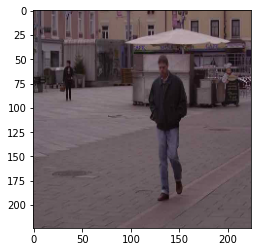

In [56]:
plt.imshow(foo)

In [39]:
from tensorflow.keras import layers
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((224,224,3), 3)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [43]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy")
filepath1 = 'unet_xception.hdf5'
checkpoint1 =keras.callbacks.ModelCheckpoint(filepath1, monitor='val_loss', verbose=0, save_best_only=True)
history= model.fit(x_train,y_train,validation_split=0.2,batch_size=2,epochs=100,callbacks=[checkpoint1])

Epoch 1/100
93/93 [==============================] - 3s 36ms/step - loss: 1.1584 - val_loss: 0.6546
Epoch 2/100
93/93 [==============================] - 2s 26ms/step - loss: 0.6238 - val_loss: 0.5882
Epoch 3/100
93/93 [==============================] - 2s 26ms/step - loss: 0.6142 - val_loss: 0.5863
Epoch 4/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6099 - val_loss: 0.6934
Epoch 5/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6094 - val_loss: 0.5896
Epoch 6/100
93/93 [==============================] - 2s 26ms/step - loss: 0.6098 - val_loss: 0.5857
Epoch 7/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6061 - val_loss: 0.5858
Epoch 8/100
93/93 [==============================] - 2s 26ms/step - loss: 0.6065 - val_loss: 0.5857
Epoch 9/100
93/93 [==============================] - 2s 26ms/step - loss: 0.6062 - val_loss: 0.5857
Epoch 10/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6064 - val_loss: 0.5862

93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 83/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 84/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5857
Epoch 85/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 86/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 87/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 88/100
93/93 [==============================] - 2s 26ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 89/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 90/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epoch 91/100
93/93 [==============================] - 2s 24ms/step - loss: 0.6050 - val_loss: 0.5856
Epo

## Tiramsu Model

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2


def relu_bn(x): return Activation('relu')(BatchNormalization(axis=-1)(x))


def conv(x, nf, sz, wd, p, stride=1):
    x = Conv2D(nf, (sz, sz), strides=(stride, stride), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(wd))(x)
    return Dropout(p)(x) if p else x


def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1):
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)


def dense_block(n, x, growth_rate, p, wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = Concatenate(axis=-1)([x, b])
        added.append(b)
    return x, added


def transition_dn(x, p, wd):
    # in the paper stride=1 but better results with stride=2
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)


def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i, n in enumerate(nb_layers):
        x, added = dense_block(n, x, growth_rate, p, wd)

        # keep track of skip connections
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added


def transition_up(added, wd=0):
    x = Concatenate(axis=-1)(added)
    _, r, c, ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform',
                 kernel_regularizer = regularizers.l2(wd))(x)


def up_path(added, skips, nb_layers, growth_rate, p, wd):
    # use previously saved list of skip connections
    for i, n in enumerate(nb_layers):
        x = transition_up(added, wd)

        # concatenate the skip connections
        x = Concatenate(axis=-1)([x, skips[i]])
        x, added = dense_block(n, x, growth_rate, p, wd)
    return x


def reverse(a): return list(reversed(a))


def create_tiramisu(nb_classes, img_input, nb_dense_block=6,
                    growth_rate=16, nb_filter=48, nb_layers_per_block=[4, 5, 7, 10, 12, 15], p=0.2, wd=1e-4):

    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else:
        nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips, added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)

    x = conv(x, 3, 1, wd, 0)
#     _, r, c, f = x.get_shape().as_list()
#     x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

In [ ]:
input_shape=(224,224,3)
img_input = Input(shape=(input_shape))

In [ ]:
x = create_tiramisu(2,img_input,2,8,48,[4,5])

In [ ]:
model = Model(img_input,x)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
 model.compile(loss='binary_crossentropy',optimizer='RMSprop', metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
model.fit(x_test,y_test,workers=16)

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")